In [1]:
# data frame (df) should be loaded/defined before the next cell

In [2]:
import os
import subprocess

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("CBRFSS")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.cores", "4")
    .config("spark.executor.instances", "4")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

file_path = "output/processedv3.parquet"

df = spark.read.parquet(file_path)

24/11/30 21:06:27 WARN Utils: Your hostname, ChandeMacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 10.89.238.200 instead (on interface en0)
24/11/30 21:06:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 21:06:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/30 21:06:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# preparing data

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline


# Define feature columns (excluding the label column 'y')
feature_columns = [
    "GENHLTH", "_AGEG5YR", "_RFHYPE6", "EMPLOY1",
    "_MICHD", "_DRDXAR2", "_HCVU653", "_RFCHOL3", "METVL12_", 
    "ALCDAY4", "_BMI5CAT", "DIFFWALK", 
    "_TOTINDA", "EDUCA", "_INCOMG1", "CHCKDNY2", "FALL12MN", "SMOKE100", "CVDINFR4"
]


# Assemble feature columns into a feature vector
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = vector_assembler.transform(df)

# Select the relevant columns for modeling
data_for_model = data_with_features.select("features", "y")

# Split the Data into 80% Training, 20% Testing
train_validation_data, test_data = data_for_model.randomSplit([0.8, 0.2], seed=42)




In [5]:
# Decision tree

# Train the Decision Tree with Hyperparameter Tuning
decision_tree = DecisionTreeClassifier(labelCol="y", featuresCol="features")

# Create a ParamGridBuilder to tune hyperparameters
param_grid = (ParamGridBuilder()
              .addGrid(decision_tree.maxDepth, [5, 6, 7, 8])  # Hyperparameters to tune
              .addGrid(decision_tree.minInstancesPerNode, [1, 2, 3])  # Tuning another hyperparameter
              .build())

# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="accuracy")

# Set up cross-validation
cross_validator = CrossValidator(estimator=decision_tree, 
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator, 
                                 numFolds=3)  # 3-fold cross-validation

# Fit the model using Cross-Validation on the combined Training + Validation Data
cv_model = cross_validator.fit(train_validation_data)

# Make Predictions on Test Data
predictions = cv_model.transform(test_data)

# Evaluate the Model on Test Data
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

# Display the decision tree structure
print(cv_model.bestModel.toDebugString)

# Group predictions by the predicted class
predictions.groupBy("prediction").count().show()

Test Accuracy: 0.85
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_665a2e1caa91, depth=7, numNodes=111, numClasses=2, numFeatures=19
  If (feature 0 <= 2.5)
   If (feature 2 <= 1.5)
    If (feature 10 <= 3.5)
     If (feature 0 <= 1.5)
      Predict: 0.0
     Else (feature 0 > 1.5)
      If (feature 7 <= 1.5)
       Predict: 0.0
      Else (feature 7 > 1.5)
       If (feature 4 <= 1.5)
        If (feature 3 <= 7.5)
         Predict: 0.0
        Else (feature 3 > 7.5)
         Predict: 1.0
       Else (feature 4 > 1.5)
        Predict: 0.0
    Else (feature 10 > 3.5)
     If (feature 7 <= 1.5)
      If (feature 1 <= 8.5)
       Predict: 0.0
      Else (feature 1 > 8.5)
       If (feature 8 <= 1.5)
        If (feature 3 <= 2.5)
         Predict: 0.0
        Else (feature 3 > 2.5)
         Predict: 1.0
       Else (feature 8 > 1.5)
        Predict: 0.0
     Else (feature 7 > 1.5)
      If (feature 3 <= 7.5)
       Predict: 0.0
      Else (feature 3 > 7.5)
       If (feature 4

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|18300|
|       1.0|  936|
+----------+-----+



In [6]:
# Analysis of decision tree

# Get feature importances from the best model found by cross-validation
importances = cv_model.bestModel.featureImportances

# Map feature importances to the feature names
feature_importance = [(name, importance) for name, importance in zip(feature_columns, importances)]
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Print sorted features by importance
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


Feature Importances:
GENHLTH: 0.4871654989571762
_RFHYPE6: 0.25653854225037265
_RFCHOL3: 0.10525999532875088
_BMI5CAT: 0.05642185164823384
ALCDAY4: 0.03853682913883315
CHCKDNY2: 0.031987169211792316
DIFFWALK: 0.01015806183898121
EMPLOY1: 0.003939449999235367
CVDINFR4: 0.0031410957868965835
EDUCA: 0.0018644840400808594
_INCOMG1: 0.0017921080460880947
METVL12_: 0.001154577878403826
_MICHD: 0.0010846337322491563
_AGEG5YR: 0.0009557021429060214
_DRDXAR2: 0.0
_HCVU653: 0.0
_TOTINDA: 0.0
FALL12MN: 0.0
SMOKE100: 0.0


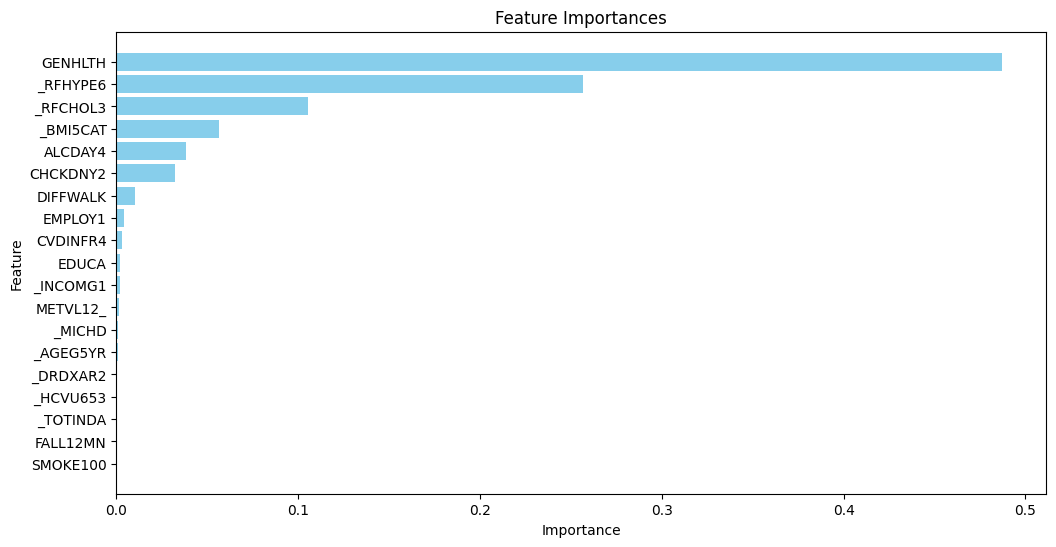

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance Visualization
def plot_feature_importance(feature_importance, feature_columns):
    # Convert to a DataFrame for easier handling
    feature_df = pd.DataFrame({
        "Feature": feature_columns,
        "Importance": feature_importance.toArray()
    }).sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_df["Feature"], feature_df["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances")
    plt.gca().invert_yaxis()  # Flip the y-axis to show the most important feature on top
    plt.show()

plot_feature_importance(cv_model.bestModel.featureImportances, feature_columns)
